# Sankey Diagram

---

## Exportação e importação (visualização em sankey)
- Usando plotly

### Tratamento dos dados

* Pegando dataset de exportação e importação realizados no mundo no ano de 2024

In [2]:
import pandas as pd

import plotly.graph_objects as go
import plotly.express as px  #paletas

d3_colors = px.colors.qualitative.D3

In [3]:
cols=[
    'period','flowCode', 'reporterDesc', 'reporterISO', 'partnerDesc', 'partnerISO', 'refYear', 'primaryValue'
]

#lendo o dataset
df = pd.read_excel("TradeData.xlsx", usecols=cols) #todas exportações de 2024
df.head()
map_df = pd.read_csv("country_continent_full.csv") #dataset de ISO/PAIS/CONTINENTE


* Unindo o dataset das infos de ISO-continente com o df existente

In [4]:
# Merge df e map_df 
df = pd.merge(df, map_df, left_on='partnerISO', right_on='ISO3', how='left')

df.rename(columns={'Continent': 'partner continent'}, inplace=True)

df.drop(['Country','ISO3'], axis=1, inplace=True)

display(df.head())

,refYear,period,reporterISO,reporterDesc,flowCode,partnerISO,partnerDesc,primaryValue,partner continent
0,2024,2024,ALB,Albania,M,W00,World,9.604259e+09,NaN
1,2024,2024,ALB,Albania,M,AFG,Afghanistan,5.307800e+02,Other/Unknown
2,2024,2024,ALB,Albania,M,ATA,Antarctica,6.387660e+02,Other/Unknown
3,2024,2024,ALB,Albania,M,DZA,Algeria,7.587345e+07,Africa
4,2024,2024,ALB,Albania,M,ASM,American Samoa,4.946630e+03,Other/Unknown


In [5]:
#Todas as exportações do Brasil

brazilExp = df[(df['reporterISO'] == 'BRA') & (df['flowCode'] == 'X') & (df['partnerISO'] != 'W00')]
brazilImp = df[(df['reporterISO'] == 'BRA') & (df['flowCode'] == 'M') & (df['partnerISO'] != 'W00')]

brazilExp.head()

,refYear,period,reporterISO,reporterDesc,flowCode,partnerISO,partnerDesc,primaryValue,partner continent
4381,2024,2024,BRA,Brazil,X,AFG,Afghanistan,3.098084e+06,Other/Unknown
4382,2024,2024,BRA,Brazil,X,ALB,Albania,1.005799e+08,Europe
4383,2024,2024,BRA,Brazil,X,ATA,Antarctica,1.272530e+05,Other/Unknown
4384,2024,2024,BRA,Brazil,X,DZA,Algeria,2.567007e+09,Africa
4385,2024,2024,BRA,Brazil,X,ASM,American Samoa,8.736590e+05,Other/Unknown


##  

#### 1. Primeira visualização: exportação brasil -> seus top n parceiros 

In [6]:
# Filtrar Brasil exportações
brazilExp = df[(df['reporterISO'] == 'BRA') &
               (df['flowCode'] == 'X') &
               (df['partnerISO'] != 'W00')]

# Top n parceiros por valor
n = 15

top_partners = brazilExp.groupby("partnerDesc")["primaryValue"].sum().nlargest(n).reset_index()

# Criar labels (Brasil + parceiros)
labels = ["Brazil"] + top_partners["partnerDesc"].tolist()

# Links
source = [0] * len(top_partners)  # sempre Brasil
target = list(range(1, len(labels)))  # cada parceiro
value = top_partners["primaryValue"].tolist()



def hex_to_rgba(hex_color: str, alpha: float = 0.5) -> str:
    h = hex_color.lstrip('#')
    r, g, b = int(h[0:2], 16), int(h[2:4], 16), int(h[4:6], 16)
    return f'rgba({r},{g},{b},{alpha})'

palette = {label: d3_colors[i % len(d3_colors)] for i, label in enumerate(labels)}

# cores dos nós na mesma ordem de 'labels'
node_colors = [palette[label] for label in labels]

# cores dos links herdando a cor do nó de origem (links_source são índices de 'labels')
link_colors = [hex_to_rgba(palette[labels[s]], 0.5) for s in source]


# Construir Sankey
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=node_colors
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=link_colors
    )
)])

fig.update_layout(title_text=f" 🌎 Exportações do Brasil - Top {n} Parceiros", font_size=12)
fig.show()


#### 2. Adicionando mais um nó ao grafico, permitindo informação de quantidade exportada por continente e por pais

In [7]:
# Filtrar Brasil exportações
brazilExp = df[(df['reporterISO'] == 'BRA') &
               (df['flowCode'] == 'X') &
               (df['partnerISO'] != 'W00')]

# Top n países por valor (agrupando também por continente)

n = 20
top_partners = brazilExp.groupby(["partnerDesc", "partner continent"])["primaryValue"].sum().nlargest(20).reset_index()

# Labels
labels = ["Brazil"]
continents = top_partners["partner continent"].unique().tolist()
labels.extend(continents)
labels.extend(top_partners["partnerDesc"].tolist())

# Índices para lookup
label_index = {label: i for i, label in enumerate(labels)}

# Links Brasil → Continente
links_source = []
links_target = []
links_value = []

for cont in continents:
    value = top_partners[top_partners["partner continent"] == cont]["primaryValue"].sum()
    links_source.append(label_index["Brazil"])
    links_target.append(label_index[cont])
    links_value.append(value)

# Links Continente → País
for _, row in top_partners.iterrows():
    links_source.append(label_index[row["partner continent"]])
    links_target.append(label_index[row["partnerDesc"]])
    links_value.append(row["primaryValue"])


d3_colors = px.colors.qualitative.D3  # category10

def hex_to_rgba(hex_color: str, alpha: float = 0.5) -> str:
    h = hex_color.lstrip('#')
    r, g, b = int(h[0:2], 16), int(h[2:4], 16), int(h[4:6], 16)
    return f'rgba({r},{g},{b},{alpha})'

# mapa label → cor (estável)
palette = {label: d3_colors[i % len(d3_colors)] for i, label in enumerate(labels)}

# cores dos nós, na ordem de 'labels'
node_colors = [palette[label] for label in labels]

# cores dos links herdando a cor do nó de ORIGEM
link_colors = [hex_to_rgba(palette[labels[s]], 0.5) for s in links_source]

# Sankey
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=20,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=node_colors
    ),
    link=dict(
        source=links_source,
        target=links_target,
        value=links_value,
        color=link_colors
    )
)])


fig.update_layout(title_text="🌎 Exportações do Brasil - Brasil → Continente → País (20)", font_size=12)
fig.show()

In [9]:
tradedf = pd.DataFrame()
source_labels = [labels[i] for i in links_source]
target_labels = [labels[i] for i in links_target]
tradedf.insert(0, "Source", source_labels)
tradedf.insert(1, "Target", target_labels)
tradedf.insert(2, "Value", links_value)
tradedf.to_csv("brasiltrade.csv")

#### 3.Representação com todos os parceiros comerciais do Brasil, gerando uma visualização comprometida

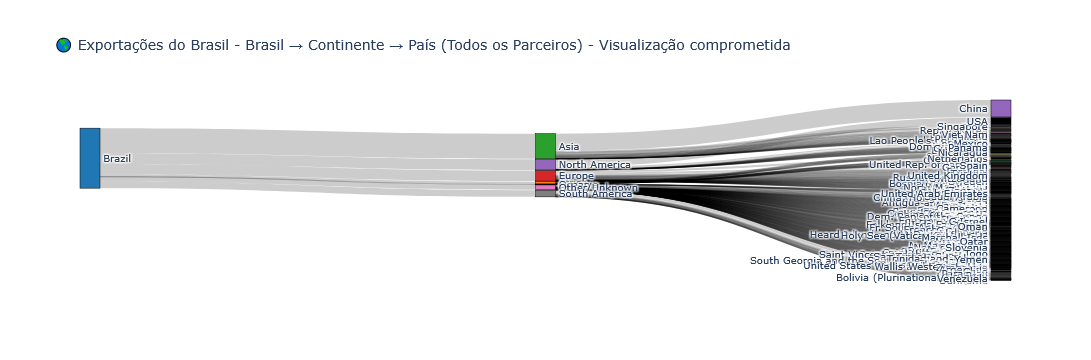

In [12]:
# Filtrar Brasil exportações
brazilExp_all = df[(df['reporterISO'] == 'BRA') &
                  (df['flowCode'] == 'X') &
                  (df['partnerISO'] != 'W00')].copy()

# Group by continent and then by country
continent_agg = brazilExp_all.groupby('partner continent')['primaryValue'].sum().reset_index()
country_agg = brazilExp_all.groupby(['partner continent', 'partnerDesc'])['primaryValue'].sum().reset_index()

# Labels
labels = ["Brazil"]
continents = continent_agg["partner continent"].tolist()
labels.extend(continents)
labels.extend(country_agg["partnerDesc"].tolist())

# Índices para lookup
label_index = {label: i for i, label in enumerate(labels)}

# Links Brasil → Continente
links_source = []
links_target = []
links_value = []

for _, row in continent_agg.iterrows():
    links_source.append(label_index["Brazil"])
    links_target.append(label_index[row["partner continent"]])
    links_value.append(row["primaryValue"])

# Links Continente → País
for _, row in country_agg.iterrows():
    if row["partner continent"] in label_index and row["partnerDesc"] in label_index:
        links_source.append(label_index[row["partner continent"]])
        links_target.append(label_index[row["partnerDesc"]])
        links_value.append(row["primaryValue"])


# Sankey
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=node_colors
    ),
    link=dict(
        source=links_source,
        target=links_target,
        value=links_value,
    )
)])

fig.update_layout(title_text="🌎 Exportações do Brasil - Brasil → Continente → País (Todos os Parceiros) - Visualização comprometida", font_size=10)
fig.show()

-----

In [ ]:
### Dados das traduções feitas em programas de pós graduação brasileiros visualizada em Sankey

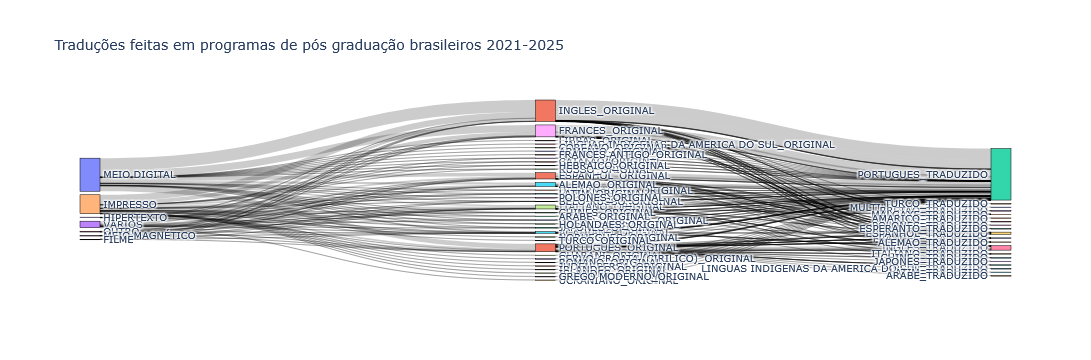

In [20]:
import json

with open("traducoes_brutas.json") as traducoes_file:
    data_traducoes = json.load(traducoes_file)

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = list(data_traducoes["labels"])
    ),
    link = dict(
      source = data_traducoes["source"],
      target = data_traducoes["target"],
      value = data_traducoes["value"]
  ))])
        
fig.update_layout(title_text="Traduções feitas em programas de pós graduação brasileiros 2021-2025", font_size=10)
fig.show()


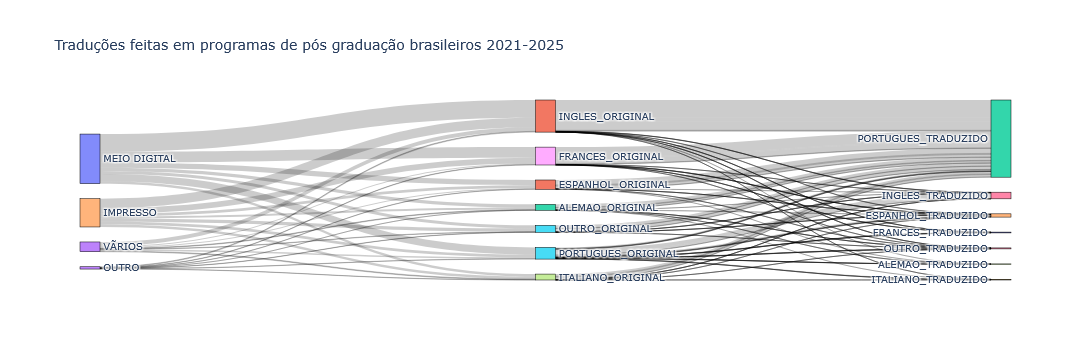

In [24]:
import json

with open("traducoes_limpas.json") as traducoes_file:
    data_traducoes = json.load(traducoes_file)

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = list(data_traducoes["labels"])
    ),
    link = dict(
      source = data_traducoes["source"],
      target = data_traducoes["target"],
      value = data_traducoes["value"]
  ))])
        
fig.update_layout(title_text="Traduções feitas em programas de pós graduação brasileiros 2021-2025", font_size=10)
fig.show()


In [80]:
steamdf = pd.read_csv("shs.csv")

In [81]:
steamdf.head()

,date,category,name,change,percentage
0,2008-11-01,AMD CPU Speeds,1.4 Ghz to 1.49 Ghz,-0.0004,0.0036
1,2008-11-01,AMD CPU Speeds,1.5 Ghz to 1.69 Ghz,-0.0025,0.0224
2,2008-11-01,AMD CPU Speeds,1.7 Ghz to 1.99 Ghz,-0.0024,0.0714
3,2008-11-01,AMD CPU Speeds,2.0 Ghz to 2.29 Ghz,-0.0040,0.1343
4,2008-11-01,AMD CPU Speeds,2.3 Ghz to 2.69 Ghz,0.0001,0.0727


In [82]:
steamdf["category"].unique()

array(['AMD CPU Speeds', 'ATI Drivers', 'Audio Devices',
       'DirectX 10 GPUs',
       'DirectX 10 Systems (Vista with DirectX 10 GPU)',
       'DirectX 9 Shader Model 2.0 GPUs',
       'DirectX 9 Shader Model 2b and 3.0 GPUs', 'Drive Type',
       'Free Hard Drive Space', 'Intel CPU Speeds', 'Language',
       'MSAA Support Level', 'Microphones', 'Multi-GPU Systems',
       'Multi-Monitor Desktop Resolution', 'NVIDIA Drivers',
       'Network Speed', 'Other Settings', 'Physical CPUs',
       'Primary Display Resolution', 'Processor Vendor', 'System RAM',
       'Total Hard Drive Space', 'VRAM', 'Video Card Description',
       'Video Card Driver Name', 'Windows Version',
       'DirectX 10 Systems (Vista/Win7 & DX 10 GPU)', 'DirectX 11 GPUs',
       'DirectX 11 Systems (Vista/Win7 & DX 11 GPU)', 'OS Version',
       'VR Headsets'], dtype=object)

In [83]:
# Get 2025 tuples
last_year = steamdf[steamdf['date'] == "2025-07-01"]

In [84]:
last_year.head()

,date,category,name,change,percentage
62381,2025-07-01,Free Hard Drive Space,1 TB to 2 TB,0.0010,0.0991
62382,2025-07-01,Free Hard Drive Space,10 GB to 99 GB,-0.0016,0.1550
62383,2025-07-01,Free Hard Drive Space,100 GB to 249 GB,-0.0049,0.2256
62384,2025-07-01,Free Hard Drive Space,2 TB to 3 TB,0.0005,0.0238
62385,2025-07-01,Free Hard Drive Space,250 GB to 499 GB,-0.0018,0.2225


In [85]:
# Count occurrences of each different value if category is Video Card Description
gpu_df  = last_year[last_year['category'] == 'Video Card Description']
gpu_df = gpu_df.copy()
gpu_df.head()

,date,category,name,change,percentage
62635,2025-07-01,Video Card Description,NaN,0.0010,0.0158
62636,2025-07-01,Video Card Description,AMD AMD Custom GPU 0405,0.0000,0.0045
62637,2025-07-01,Video Card Description,AMD Radeon (TM) Graphics,0.0001,0.0030
62638,2025-07-01,Video Card Description,AMD Radeon 780M Graphics,0.0001,0.0028
62639,2025-07-01,Video Card Description,AMD Radeon Graphics,0.0006,0.0211


In [86]:
gpu_df["name"].unique()

array([nan, 'AMD AMD Custom GPU 0405', 'AMD Radeon (TM) Graphics',
       'AMD Radeon 780M Graphics', 'AMD Radeon Graphics',
       'AMD Radeon Graphics (RADV VANGOGH)', 'AMD Radeon RX 550',
       'AMD Radeon RX 5500 XT', 'AMD Radeon RX 5600 XT',
       'AMD Radeon RX 570', 'AMD Radeon RX 5700 XT', 'AMD Radeon RX 580',
       'AMD Radeon RX 580 2048SP', 'AMD Radeon RX 6500 XT',
       'AMD Radeon RX 6600', 'AMD Radeon RX 6600 XT',
       'AMD Radeon RX 6650 XT', 'AMD Radeon RX 6700 XT',
       'AMD Radeon RX 6750 XT', 'AMD Radeon RX 6800',
       'AMD Radeon RX 6800 XT', 'AMD Radeon RX 6900 XT',
       'AMD Radeon RX 7600 XT', 'AMD Radeon RX 7700 XT',
       'AMD Radeon RX 7800 XT', 'AMD Radeon RX 7900 XTX',
       'AMD Radeon Vega 3 Graphics', 'AMD Radeon Vega 8 Graphics',
       'AMD Radeon(TM) Graphics', 'Intel HD Graphics 4000',
       'Intel HD Graphics 4600', 'Intel HD Graphics 520',
       'Intel HD Graphics 620', 'Intel Iris Xe Graphics',
       'Intel UHD Graphics 600', 'Inte

In [87]:
gpu_df.sort_values(by='percentage', ascending=False, inplace=True)
gpu_df

,date,category,name,change,percentage
62736,2025-07-01,Video Card Description,Other,0.0022,0.0967
62705,2025-07-01,Video Card Description,NVIDIA GeForce RTX 3060,0.0002,0.0444
62717,2025-07-01,Video Card Description,NVIDIA GeForce RTX 4060 Laptop GPU,-0.0055,0.0424
62716,2025-07-01,Video Card Description,NVIDIA GeForce RTX 4060,-0.0004,0.0420
62683,2025-07-01,Video Card Description,NVIDIA GeForce GTX 1650,-0.0006,0.0317
...,...,...,...,...,...
62669,2025-07-01,Video Card Description,Intel UHD Graphics 600,0.0001,0.0018
62643,2025-07-01,Video Card Description,AMD Radeon RX 5600 XT,0.0001,0.0018
62664,2025-07-01,Video Card Description,Intel HD Graphics 4000,0.0016,0.0016
62642,2025-07-01,Video Card Description,AMD Radeon RX 5500 XT,0.0000,0.0015


In [88]:
gpu_df["name"].fillna("Unknown", inplace=True)

/tmp/ipykernel_98773/439689244.py:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [89]:
nvidia = gpu_df[gpu_df['name'].str.contains("NVIDIA")]
amd = gpu_df[gpu_df['name'].str.contains("AMD")]
intel = gpu_df[gpu_df['name'].str.contains("Intel")]

In [90]:
nvidiasum = nvidia['percentage'].sum()
amdsum = amd['percentage'].sum()
intelsum = intel['percentage'].sum()
unknownsum = gpu_df[~gpu_df['name'].str.contains("NVIDIA|AMD|Intel")]['percentage'].sum()
print(nvidiasum, amdsum, intelsum, unknownsum)

0.6894999999999998 0.14070000000000002 0.05739999999999999 0.11249999999999999


In [96]:
labels = ["All","NVIDIA","AMD","Intel","Unknown"]
source_links = [0,0,0,0]
target_links = [1,2,3,4]
value_links = [nvidiasum, amdsum, intelsum, unknownsum]
for i, value in enumerate(value_links):
    value_links[i] = int(round(value,2)*100)

In [97]:
go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = labels
    ),
    link = dict(
      source = source_links,
      target = target_links,
      value = value_links
  ))])

In [98]:
nvidia = nvidia.head(5)
amd = amd.head(5)
intel = intel.head(5)
nvidia

,date,category,name,change,percentage
62705,2025-07-01,Video Card Description,NVIDIA GeForce RTX 3060,0.0002,0.0444
62717,2025-07-01,Video Card Description,NVIDIA GeForce RTX 4060 Laptop GPU,-0.0055,0.0424
62716,2025-07-01,Video Card Description,NVIDIA GeForce RTX 4060,-0.0004,0.0420
62683,2025-07-01,Video Card Description,NVIDIA GeForce GTX 1650,-0.0006,0.0317
62700,2025-07-01,Video Card Description,NVIDIA GeForce RTX 3050,-0.0005,0.0295


In [99]:
for line in nvidia.itertuples():
    source_links.append(1)
    target_links.append(len(labels))
    value_links.append(int(round(line.percentage,2)*100))
    labels.append(line.name)
for line in amd.itertuples():
    source_links.append(2)
    target_links.append(len(labels))
    value_links.append(int(round(line.percentage,2)*100))
    labels.append(line.name)
for line in intel.itertuples():
    source_links.append(3)
    target_links.append(len(labels))
    value_links.append(int(round(line.percentage,2)*100))
    labels.append(line.name)


In [100]:
go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = labels
    ),
    link = dict(
      source = source_links,
      target = target_links,
      value = value_links
  ))])


In [101]:
dfsteam = pd.DataFrame()
dfsteam.insert(0, "Source", [labels[i] for i in source_links])
dfsteam.insert(1, "Target", [labels[i] for i in target_links])
dfsteam.insert(2, "Value", value_links)
dfsteam

,Source,Target,Value
0,All,NVIDIA,69
1,All,AMD,14
2,All,Intel,6
3,All,Unknown,11
4,NVIDIA,NVIDIA GeForce RTX 3060,4
5,NVIDIA,NVIDIA GeForce RTX 4060 Laptop GPU,4
6,NVIDIA,NVIDIA GeForce RTX 4060,4
7,NVIDIA,NVIDIA GeForce GTX 1650,3
8,NVIDIA,NVIDIA GeForce RTX 3050,3
9,AMD,AMD Radeon Graphics,2


In [ ]:
dfsteam.to_csv("steamgpu.csv")